In [19]:
import os
import io
import lmdb
import torch
import numpy as np
import pandas as pd
import h5py
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF
from torchvision.io import decode_image
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Union
import warnings


# --------------------------------------------------------
# LMDB tile view
# --------------------------------------------------------
class SlideFeatureView:
    """Loads tiles from a per-slide LMDB and features from h5 or pt."""

    def __init__(
        self,
        lmdb_env: lmdb.Environment,
        lmdb_keys: List[str],                  # ordered tile keys
        feature_path: Optional[str],
        image_mode: str = "RGB",
        patch_transform: Optional[Any] = None,
        included_idxs: Optional[np.ndarray] = None,
    ):
        self.lmdb_env = lmdb_env
        self.lmdb_keys = lmdb_keys
        self.feature_path = feature_path
        self.image_mode = image_mode
        self.patch_transform = patch_transform

        if included_idxs is not None:
            self.included_idxs = np.asarray(included_idxs)
        else:
            self.included_idxs = None

        if feature_path:
            if feature_path.endswith(".h5"):
                self.feature_type = "h5"
            elif feature_path.endswith(".pt"):
                self.feature_type = "pt"
            else:
                raise ValueError(f"Unsupported feature file: {feature_path}")

    def __len__(self):
        return len(self.lmdb_keys)

    def _map_idxs(self, idxs):
        if idxs is None:
            return self.included_idxs if self.included_idxs is not None else np.arange(len(self.lmdb_keys))
        idxs = np.asarray(idxs)
        if self.included_idxs is not None:
            return self.included_idxs[idxs]
        return idxs

    # --------------------------------------------------------
    # Tile loader (LMDB only)
    # --------------------------------------------------------
    def fetch_tiles(self, idxs=None):
        sel = idxs if idxs is not None else range(len(self.lmdb_keys))
        out = []

        with self.lmdb_env.begin(write=False) as txn:
            for i in sel:
                key = self.lmdb_keys[i]
                raw = txn.get(key.encode())

                # raw is already bytes from LMDB
                buf = torch.frombuffer(raw, dtype=torch.uint8)  # zero copy view
                img = decode_image(buf, mode=self.image_mode)    # uint8 tensor CxHxW

                # maintain your transform path
                if self.patch_transform:
                    t = self.patch_transform(img)
                else:
                    # decode_image already returns a tensor; convert to float if needed
                    t = img.float().div(255)

                out.append(t)

        return torch.stack(out, 0) if out else torch.empty((0, 3, 1, 1))

    # --------------------------------------------------------
    # Feature loader
    # --------------------------------------------------------
    def fetch_features(self, idxs=None):
        if self.feature_path is None:
            raise ValueError("No feature file")

        abs_idxs = idxs

        if self.feature_type == "h5":
            with h5py.File(self.feature_path, "r") as f:
                feats = f["features"][abs_idxs]
            return torch.from_numpy(feats).float()

        data = torch.load(self.feature_path, map_location="cpu")
        feats = data["features"] if isinstance(data, dict) else data
        return feats[abs_idxs].float()

    def fetch_coords(self, idxs=None):
        if self.feature_path is None:
            raise ValueError("No feature file")
        abs_idxs = self._map_idxs(idxs)

        if self.feature_type == "h5":
            with h5py.File(self.feature_path, "r") as f:
                return f["coords"][abs_idxs]

        data = torch.load(self.feature_path, map_location="cpu")
        arr = data["coords"].numpy() if isinstance(data["coords"], torch.Tensor) else np.asarray(data["coords"])
        return arr[abs_idxs]

    def fetch_patch_indices(self, idxs=None):
        if self.feature_path is None:
            raise ValueError("No feature file")
        abs_idxs = self._map_idxs(idxs)

        if self.feature_type == "h5":
            with h5py.File(self.feature_path, "r") as f:
                return f["patch_grid_idx"][abs_idxs]

        data = torch.load(self.feature_path, map_location="cpu")
        arr = data["patch_grid_idx"].numpy() if isinstance(data["patch_grid_idx"], torch.Tensor) else np.asarray(data["patch_grid_idx"])
        return arr[abs_idxs]


@dataclass
class SlideRecord:
    slide_id: str
    label: int
    coords: np.ndarray
    lmdb_pth: str                     # path to LMDB for this slide
    lmdb_keys: List[str]              # tile keys inside LMDB
    feature_uri: Optional[str]
    included_idxs: Optional[np.ndarray]


# --------------------------------------------------------
# Slide-level dataset, LMDB-only
# --------------------------------------------------------
class SlideDatasetLMDB(Dataset):
    def __init__(
        self,
        split: Union[str, Sequence[str]],
        tiles_parquet: str,
        labels_parquet: str,
        splits_parquet: str,
        features_parquet: str,
        image_mode: str = "RGB",
        lowres_size: tuple[int, int] = (256, 256),
        lowres_transform: Optional[Any] = None,
        patch_transform: Optional[Any] = None,
        task_type: str = "classification",
    ):
        super().__init__()

        assert task_type in {"classification", "regression"}
        self.task_type = task_type
        self.image_mode = image_mode
        self.lowres_size = lowres_size
        self.lowres_transform = lowres_transform
        self.patch_transform = patch_transform

        tiles_df = pd.read_parquet(tiles_parquet)
        labels_df = pd.read_parquet(labels_parquet)
        splits_df = pd.read_parquet(splits_parquet)
        feats_df = pd.read_parquet(features_parquet)

        if isinstance(split, str):
            split_values = [split]
        else:
            split_values = list(split)

        slide_ids = set(splits_df.loc[splits_df["split"].isin(split_values), "slide_id"])

        labels_df = labels_df[labels_df["slide_id"].isin(slide_ids)]

        if task_type == "classification":
            raw = labels_df.set_index("slide_id")["label"]
            if not np.issubdtype(raw.dtype, np.number):
                cats = sorted(raw.unique().tolist())
                mapping = {c: i for i, c in enumerate(cats)}
                labels = {sid: mapping[lbl] for sid, lbl in raw.items()}
            else:
                labels = {r.slide_id: int(r.label) for r in labels_df.itertuples(index=False)}
        else:
            labels = {r.slide_id: float(r.label) for r in labels_df.itertuples(index=False)}

        need = {"slide_id", "patch_grid_idx", "x", "y", "patch_uri", "lmdb_pth", "include"}
        if not need.issubset(tiles_df.columns):
            raise RuntimeError("tiles.parquet missing required columns for LMDB mode")

        tiles_df = tiles_df[
            (tiles_df["slide_id"].isin(slide_ids)) &
            tiles_df["include"].astype(bool)
        ].copy()

        feat_map = {r.slide_id: r.feature_uri for r in feats_df.itertuples(index=False)}

        self.records = []
        for sid, g in tiles_df.groupby("slide_id", sort=True):

            if sid not in labels:
                continue

            g = g.sort_values("patch_grid_idx").reset_index(drop=True)
            coords = g[["x", "y"]].to_numpy(np.int64)
            lmdb_pth = g["lmdb_pth"].iloc[0]      # same LMDB for slide
            lmdb_keys = g["patch_uri"].tolist()   # the tile keys inside LMDB
            included_idxs = g["patch_grid_idx"].to_numpy(np.int64)
            feature_uri = feat_map.get(sid)

            self.records.append(
                SlideRecord(
                    slide_id=sid,
                    label=labels[sid],
                    coords=coords,
                    lmdb_pth=lmdb_pth,
                    lmdb_keys=lmdb_keys,
                    feature_uri=feature_uri,
                    included_idxs=included_idxs,
                )
            )

        self._env_cache = {}

    def _get_env(self, path):
        if path in self._env_cache:
            return self._env_cache[path]
        env = lmdb.open(path, readonly=True, lock=False, readahead=False, max_readers=512)
        self._env_cache[path] = env
        return env

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]

        env = self._get_env(rec.lmdb_pth)

        view = SlideFeatureView(
            lmdb_env=env,
            lmdb_keys=rec.lmdb_keys,
            feature_path=rec.feature_uri,
            image_mode=self.image_mode,
            patch_transform=self.patch_transform,
            included_idxs=rec.included_idxs,
        )

        dtype = torch.float if self.task_type == "regression" else torch.long

        return {
            "slide_id": rec.slide_id,
            "label": torch.tensor(rec.label, dtype=dtype),
            "coords": rec.coords,
            "view": view,
        }


In [41]:
import pandas as pd
from pathlib import Path

tiles_df = pd.read_parquet("/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/tiles.parquet")

# Extract slide_id → list of full patch paths
slide_to_files = (
    tiles_df
    .groupby("slide_id")["patch_uri"]
    .apply(list)
    .to_dict()
)

# Also extract slide_id → list of basenames (keys for LMDB)
slide_to_keys = {
    slide_id: [Path(p).name for p in paths]
    for slide_id, paths in slide_to_files.items()
}

slide_ids = list(slide_to_files.keys())

print("Num slides:", len(slide_ids))
print("Example:", slide_ids[0])
print("Example files:", slide_to_files[slide_ids[0]][:5])
print("Example LMDB keys:", slide_to_keys[slide_ids[0]][:5])

KeyboardInterrupt: 

In [40]:
import os, lmdb
from tqdm import tqdm

def create_lmdb_from_paths(slide_id, file_list, out_dir, map_size=1e10):
    os.makedirs(out_dir, exist_ok=True)
    lmdb_path = os.path.join(out_dir, f"{slide_id}.lmdb")
    env = lmdb.open(lmdb_path, map_size=int(map_size))

    with env.begin(write=True) as txn:
        for fpath in file_list:
            key = os.path.basename(fpath)
            with open(fpath, "rb") as f:
                txn.put(key.encode(), f.read())

    env.close()
    return lmdb_path


In [3]:
from joblib import Parallel, delayed

out_dir = "/media/ssd1/van/lusc-luad_lmdb"

items = list(slide_to_files.items())

# slide_to_files: dict {slide_id: [full_patch_paths]}
results = Parallel(n_jobs=64, backend="multiprocessing")(
    delayed(create_lmdb_from_paths)(sid, flist, out_dir)
    for sid, flist in tqdm(items)
)


100%|██████████| 1043/1043 [03:08<00:00,  5.52it/s]


In [39]:
df = pd.read_parquet("/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/lmdb_version/new_tiles.parquet")
df.slide_id.unique()

array(['TCGA-77-8136-01Z-00-DX1.15cdacc3-ee04-4323-b5e4-4f6d7085bd38',
       'TCGA-85-6561-01Z-00-DX1.7bb9f936-00e1-4014-a6ae-8dc1c64d7f42',
       'TCGA-78-7153-01Z-00-DX1.5190321a-f1aa-4c6e-b4b9-6767b779682b'],
      dtype=object)

In [42]:
import os
import pandas as pd

# ------------------------------------------
# Paths
# ------------------------------------------
lmdb_dir = "/media/ssd1/van/lusc-luad_lmdb"
orig_tiles = "../data/tcga_luad_lusc/parquet/tiles.parquet"

out_dir = "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/lmdb_version"
os.makedirs(out_dir, exist_ok=True)
out_splits = os.path.join(out_dir, "new_splits.parquet")
out_tiles  = os.path.join(out_dir, "new_tiles.parquet")

# ------------------------------------------
# 1. Get slide IDs from LMDB directory
# ------------------------------------------
lmdb_files = [f for f in os.listdir(lmdb_dir) if f.endswith(".lmdb")]
slide_ids = sorted([f.replace(".lmdb", "") for f in lmdb_files])

print("Found", len(slide_ids), "slides in LMDB dir.")
print(slide_ids[:5])

# ------------------------------------------
# 2. Write splits_parquet
# ------------------------------------------
splits_df = pd.DataFrame({
    "slide_id": slide_ids,
    "split": ["train"] * len(slide_ids)
})

splits_df.to_parquet(out_splits, index=False)
print("Wrote", out_splits)

# ------------------------------------------
# 3. Build new tiles.parquet
# ------------------------------------------
tiles_df = pd.read_parquet(orig_tiles)

# Filter to only slides present in LMDB directory
tiles_df = tiles_df[tiles_df["slide_id"].isin(slide_ids)].copy()

# Create new column for LMDB path
tiles_df["lmdb_pth"] = tiles_df["slide_id"].apply(
    lambda sid: os.path.join(lmdb_dir, f"{sid}.lmdb")
)

# Modify patch_uri to just be the basename (LMDB key)
tiles_df["patch_uri"] = tiles_df["patch_uri"].apply(os.path.basename)

# Make sure include exists; if not, set True
if "include" not in tiles_df.columns:
    tiles_df["include"] = True

# Keep only required columns in correct order
new_tiles_df = tiles_df[[
    "slide_id",
    "patch_grid_idx",
    "x", "y",
    "lmdb_pth",
    "patch_uri",
    "include",
]]

new_tiles_df.to_parquet(out_tiles, index=False)
print("Wrote", out_tiles)

print("Done.")


Found 1043 slides in LMDB dir.
['TCGA-05-4244-01Z-00-DX1.d4ff32cd-38cf-40ea-8213-45c2b100ac01', 'TCGA-05-4245-01Z-00-DX1.36ff5403-d4bb-4415-b2c5-7c750d655cde', 'TCGA-05-4249-01Z-00-DX1.9fce0297-cc19-4c04-872c-4466ee4024db', 'TCGA-05-4250-01Z-00-DX1.90f67fdf-dff9-46ca-af71-0978d7c221ba', 'TCGA-05-4382-01Z-00-DX1.76b49a4c-dbbb-48b0-b677-6d3037e5ce88']
Wrote /home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/lmdb_version/new_splits.parquet
Wrote /home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/lmdb_version/new_tiles.parquet
Done.


In [43]:
new_tiles_df

,slide_id,patch_grid_idx,x,y,lmdb_pth,patch_uri,include
0,TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB...,0,0,0,/media/ssd1/van/lusc-luad_lmdb/TCGA-18-3406-01...,patch_000000.jpg,False
1,TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB...,1,444,0,/media/ssd1/van/lusc-luad_lmdb/TCGA-18-3406-01...,patch_000001.jpg,False
2,TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB...,2,888,0,/media/ssd1/van/lusc-luad_lmdb/TCGA-18-3406-01...,patch_000002.jpg,False
3,TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB...,3,1333,0,/media/ssd1/van/lusc-luad_lmdb/TCGA-18-3406-01...,patch_000003.jpg,False
4,TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB...,4,1777,0,/media/ssd1/van/lusc-luad_lmdb/TCGA-18-3406-01...,patch_000004.jpg,False
...,...,...,...,...,...,...,...
33986479,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,45995,99722,88199,/media/ssd1/van/lusc-luad_lmdb/TCGA-S2-AA1A-01...,patch_045995.jpg,True
33986480,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,45996,100166,88199,/media/ssd1/van/lusc-luad_lmdb/TCGA-S2-AA1A-01...,patch_045996.jpg,True
33986481,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,45997,100609,88199,/media/ssd1/van/lusc-luad_lmdb/TCGA-S2-AA1A-01...,patch_045997.jpg,True
33986482,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,45998,101052,88199,/media/ssd1/van/lusc-luad_lmdb/TCGA-S2-AA1A-01...,patch_045998.jpg,True


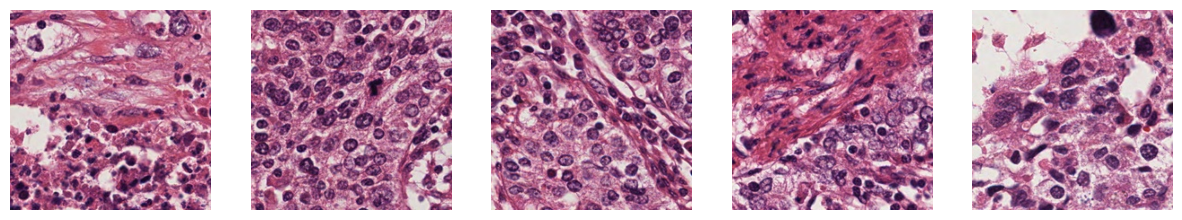

In [19]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

base = Path("/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/lmdb_version")

tiles_parquet  = base / "new_tiles.parquet"
splits_parquet = base / "new_splits.parquet"

labels_parquet  = "../data/tcga_luad_lusc/parquet/slide_labels.parquet"
features_parquet = "../data/tcga_luad_lusc/parquet/features.parquet"

ds = SlideDatasetLMDB(
    split="train",
    tiles_parquet=str(tiles_parquet),
    labels_parquet=labels_parquet,
    splits_parquet=str(splits_parquet),
    features_parquet=features_parquet,
    image_mode="RGB",
    patch_transform=None,
    lowres_transform=None,
    task_type="classification",
)

import random

sample = ds[0]
view = sample["view"]

N = len(view)
idxs = random.sample(range(N), 5)

tiles = view.fetch_tiles(idxs)

fig, axs = plt.subplots(1, len(idxs), figsize=(15, 3))
for ax, t in zip(axs, tiles):
    img = t.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis("off")
plt.show()

In [20]:
import sys 
sys.path.append("..")
from src.data.datasets import SlideDataset 

ds = SlideDataset(
    split="train",    # or ["train"] if you want explicit list
    tiles_parquet="../data/tcga_luad_lusc/parquet/tiles.parquet",
    labels_parquet="../data/tcga_luad_lusc/parquet/slide_labels.parquet",
    splits_parquet="../data/tcga_luad_lusc/parquet/split_1.parquet",
    features_parquet="../data/tcga_luad_lusc/parquet/features.parquet"
)

base = Path("/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/lmdb_version")

tiles_parquet  = base / "new_tiles.parquet"
splits_parquet = base / "new_splits.parquet"

labels_parquet  = "../data/tcga_luad_lusc/parquet/slide_labels.parquet"
features_parquet = "../data/tcga_luad_lusc/parquet/features.parquet"

ds_lmdb = SlideDatasetLMDB(
    split="train",
    tiles_parquet=str(tiles_parquet),
    labels_parquet=labels_parquet,
    splits_parquet=str(splits_parquet),
    features_parquet=features_parquet,
    image_mode="RGB",
    patch_transform=None,
    lowres_transform=None,
    task_type="classification",
)

/home/dog/Documents/van/wsi_samp/notebooks/../src/data/datasets.py:232: UserWarning: No lowres thumbnails found; using first tile as fallback.
  warnings.warn("No lowres thumbnails found; using first tile as fallback.")


In [34]:
import time, random
import numpy as np

# -------- benchmark helper --------
def benchmark_fetch(ds, name):
    t0 = time.time()
    sample = ds[0]
    view = sample["view"]

    N = len(view)
    idxs = random.sample(range(N), 1024)   # bump to 32 for a more stable benchmark

    
    tiles = view.fetch_tiles(idxs)
    t1 = time.time()

    print(f"{name}: {t1 - t0:.4f} sec")
    return tiles

# -------- run both --------
print("Benchmarking directory version...")
tiles_dir = benchmark_fetch(ds, "dir-tiles")

print("Benchmarking LMDB version...")
tiles_lmdb = benchmark_fetch(ds_lmdb, "lmdb-tiles")


Benchmarking directory version...
dir-tiles: 1.4813 sec
Benchmarking LMDB version...
lmdb-tiles: 5.8151 sec
